In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
pgf_with_rc_fonts = {
    "text.usetex": True,
    "text.latex.unicode": True,
    "font.family": "serif",
    "font.serif": [],                   # use latex default serif font
    "font.sans-serif": ["DejaVu Sans"], # use a specific sans-serif font
    "pgf.preamble": [
        r'\usepackage{amsmath}',
        r'\usepackage{gensymb}',
        r'\usepackage{siunitx}',
        r'\DeclareSIUnit{\revolution}{rev}',
    ]
}
matplotlib.rcParams.update(pgf_with_rc_fonts)

import matplotlib.pyplot as plt

import pandas as pd
import os

# Background Color
bg = '#d3e9f8'

import ingest
import numpy as np
df = ingest.setup('../../valid/capture/capture1')

Dropped 1 outlier coordinate


In [2]:
import warnings
from bearing_error import error, error_methods, smoothing_methods
warnings.filterwarnings('ignore')
errors = error(df, list(error_methods.keys()))
#errors_uncorrected = ingest.error(ingest.error_methods, true_bearing=False)
#errors_dbm = ingest.error(ingest.error_methods, mw=False)

HBox(children=(IntProgress(value=0, description='Preparing data', max=4342), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Interpolating', max=47762), HTML(value='')))

In [3]:
# Print the median results by method
for smooth in pd.unique(errors.smooth):
    errors_display = errors[errors.smooth==smooth].groupby(['method'])['error'].apply(lambda x: pd.Series.median(pd.Series.abs(x))).sort_values()
    #errors_display.plot(kind='bar', title="Overall")
    print(errors_display)
errors_display = errors[errors.smooth.isnull()].groupby(['method'])['error'].apply(lambda x: pd.Series.median(pd.Series.abs(x))).sort_values()
#errors_display.plot(kind='bar', title="Overall")
print(errors_display)

# Errors in dbm
#errors_display_dbm = errors_display = errors_dbm.groupby('method')['error'].apply(lambda x: pd.Series.median(pd.Series.abs(x))).sort_values()
#print(errors_display_dbm)

Series([], Name: error, dtype: float64)
method
PCHIP          13.697475
BPoly          14.312019
Naive          14.697475
SLinear        14.827605
Linear         15.092330
Akima          16.441210
Barycentric    22.827605
Cubic          24.942384
Quadratic      25.697475
Krogh          59.284347
Random         90.374420
Name: error, dtype: float64


In [4]:
errors_display = errors.groupby(['method'])['error'].apply(lambda x: pd.Series.median(pd.Series.abs(x))).sort_values()
#errors_display.plot(kind='bar', title="Overall")
print(errors_display)

method
PCHIP          13.697475
BPoly          14.312019
Naive          14.697475
SLinear        14.827605
Linear         15.092330
Akima          16.441210
Barycentric    22.827605
Cubic          24.942384
Quadratic      25.697475
Krogh          59.284347
Random         90.374420
Name: error, dtype: float64


count    4342.000000
mean       -5.135848
std        56.848532
min      -179.795704
25%       -18.450764
50%        -5.997662
75%        11.089209
max       179.942384
Name: error, dtype: float64

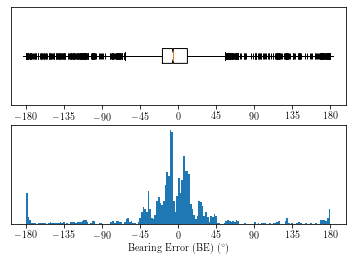

In [76]:
errpchip = errors[errors.method=='PCHIP'].error

f, (ax1, ax2) = plt.subplots(2, sharex=False)
ax1.boxplot(errpchip, 1, vert=False, sym='+')

# label = f"Optimal CHD (median: {format(data['discovery-hop-dist-2'].median(), '.2f')} "
plt.rcParams["figure.figsize"] = [6, 4]
ax1.set_yticklabels([])
ax2.set_yticklabels([])
ax1.tick_params(axis='y', which=u'both',length=0)
ax2.tick_params(axis='y', which=u'both',length=0)
ax1.set_xticks([x for x in range(-180,181,45)])
ax2.set_xticks([x for x in range(-180,181,45)])

plt.xlabel(r'Bearing Error (BE)  ($^\circ$)')


ax2.hist(errpchip, 180)
#plt.savefig('pchiperr.pgf')

errpchip.describe()

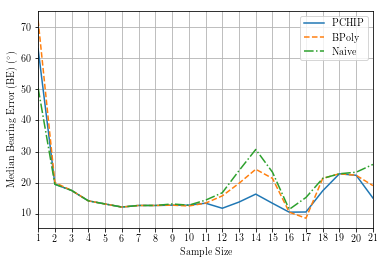

In [73]:
# For display purposes, eliminate Random and Krogh
median_errors = errors.groupby(['method', 'samples'])['error'].apply(lambda x: pd.Series.median(pd.Series.abs(x))).unstack().T
median_errors_reduced = median_errors[['PCHIP', 'BPoly', 'Naive']]
#median_errors_reduced = median_errors
ax = median_errors_reduced.plot(xticks=median_errors_reduced.index.values, grid=True, style=['-','--','-.',':'])
ax.set_ylabel("Median Bearing Error (BE) ($^\circ$)")
ax.set_xlabel("Sample Size")
ax.legend(bbox_to_anchor=(1,1))
plt.savefig('interpolation_grid.pgf')

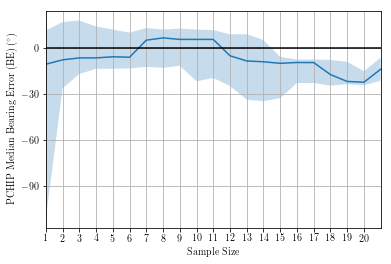

In [77]:
pchip = errors[errors.method=='PCHIP'].groupby('samples')['error']
pchip_median = pchip.apply(lambda x: pd.Series.median(pd.Series.abs(x)))
pchip_error = pchip.std()
pchip_lq = pchip.quantile([0.25])
pchip_uq = pchip.quantile([0.75])
pchip_med = pchip.quantile([0.50])
pchip_min = pchip.quantile([0])
pchip_max = pchip.quantile([1])

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(pchip_med.index.get_level_values(level=0), pchip_med.values)
ax.fill_between(pchip_med.index.get_level_values(level=0), pchip_lq.values, pchip_uq.values, antialiased=True, alpha=0.25, linestyle='-')

# # ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel("PCHIP Median Bearing Error (BE) ($^\circ$)")
ax.set_xlabel("Sample Size")
ax.set_xticks([x for x in range(0, 21)])
ax.set_yticks([y for y in range(-120,181,30)])
ax.set_xlim([1,21])
ax.grid()
ax.plot([0,21],[0,0],'k')
#plt.savefig('interpolation_pchip.pgf')

Text(0.5,0,'Sample Size')

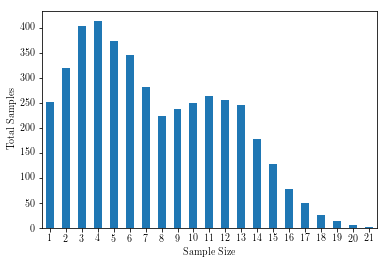

In [79]:
sample_spread = errors[errors['method']=='Naive'].groupby(['samples'])['error'].count().T

fig = plt.figure()
ax = plt.subplot(111)
sample_spread.plot(ax = ax, kind='bar', stacked=True)
plt.xticks(rotation=0)
ax.set_ylabel("Total Samples")
ax.set_xlabel("Sample Size")
#plt.savefig('interpolation_spread.pgf')

# variance_spread = errors[errors['method']=='Naive'].groupby(['test','samples'])['error'].var().unstack().T
# variance_spread.plot(kind='bar', stacked=True, title="Variance per Sample Size")


Test: capture-2, BSSID: 00:12:17:9f:79:b6, PASS: 56


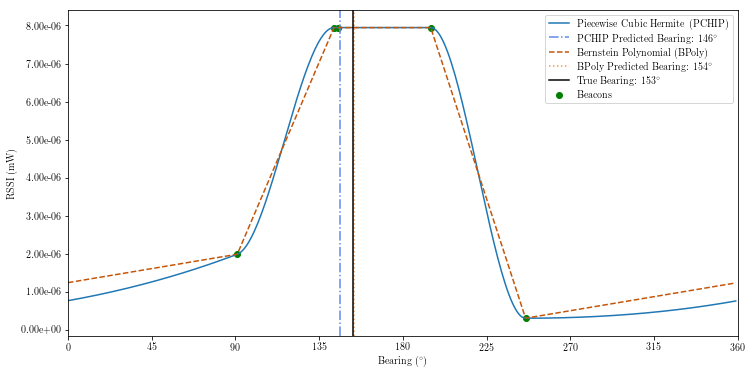

In [62]:
import locate, pylab, capmap
from bearing_error import prep_for_plot
import matplotlib.ticker as mtick
def get_nsample_set(n):
    rando = errors[(errors['samples']==n) & (errors['method']=='Naive')].reset_index()
    i = np.random.randint(len(rando))
    test = rando.iloc[i]['test']
    pass_n = rando.iloc[i]['pass']
    bssid = rando.iloc[i]['bssid']
    return ingest.get_set(test, pass_n, bssid), test, bssid, pass_n

#the_set, test, bssid, pass_n = get_nsample_set(5)
test = 'capture-2'
bssid = '00:12:17:9f:79:b6'
pass_n = 56 
the_set = ingest.get_set(test, pass_n, bssid)

series = prep_for_plot(the_set)
truth = capmap.get_bearing(test,bssid)

interpPCHIP = locate.interpolate(series, 'PCHIP')
interpPCHIPg = interpPCHIP.idxmax()
            #ax.axvline(np.radians(truth), 0, 1, color='k', linestyle='-.', label="True Bearing")
#style=['-','--','-.',':']
interpBPoly = locate.interpolate(series, 'BPoly')
interpBPolyg = interpBPoly.idxmax()
series = series.reindex(np.arange(0, 360))
naiveg = series.idxmax()

ax = interpPCHIP.plot(label='Piecewise Cubic Hermite (PCHIP)', linestyle='-')
ax.axvline(interpPCHIPg, color='xkcd:soft blue', linestyle='-.', label="PCHIP Predicted Bearing: {}$^\circ$".format(interpPCHIPg))
interpBPoly.plot(ax=ax, color='xkcd:rust orange', label='Bernstein Polynomial (BPoly)', linestyle='--')
ax.axvline(interpBPolyg, color='xkcd:faded orange', linestyle=':', label="BPoly Predicted Bearing: {}$^\circ$".format(interpBPolyg))
ax.axvline(truth, color='k', linestyle='-', label="True Bearing: {}$^\circ$".format(int(truth)))
ax.scatter(series.index, series, color='green', label='Beacons')
ax.set_xticks([x for x in range(0,361,45)])
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
ax.set_ylabel("RSSI (mW)")
ax.set_xlabel("Bearing ($^\circ$)")
ax.legend(bbox_to_anchor=(1,1))

plt.rcParams["figure.figsize"] = [12, 6]
plt.savefig('interpolation.pgf')
print ("Test: {}, BSSID: {}, PASS: {}".format(test, bssid, pass_n))

# GOOD TESTS: 
# Test: capture-2, BSSID: 00:12:17:9f:79:b6, PASS: 56 

In [143]:
# Show the best methods for each number of samples
ntop = 5
idx = pd.MultiIndex.from_product([['method','error'],range(0,5)])
top_methods = median_errors.T.apply(lambda x: pd.Series(pd.concat([pd.Series(x.nsmallest(ntop).index, dtype=np.dtype(object)), pd.Series(x.nsmallest(ntop).values, dtype=np.dtype(object))])))
top_methods.set_index(idx, inplace=True)
top_methods = top_methods.swaplevel(1,0).sort_index()
top_methods

samples          1        2        3        4        5        6        7   \
0 error     26.7555  19.4412  17.4412   14.082   13.082  12.0892  12.6009   
  method    SLinear    Naive    BPoly    PCHIP    Akima    Akima    BPoly   
1 error     26.9523  19.4539  17.4412  14.0923   13.082  12.0892  12.6009   
  method      Akima    PCHIP   Linear    BPoly    PCHIP    BPoly   Linear   
2 error     26.9523  19.4539  17.4412  14.0923  13.0872  12.0892  12.6009   
  method      Krogh  SLinear    Naive   Linear    BPoly    PCHIP    Naive   
3 error     26.9523  19.9704  17.4412  14.0923  13.0872  12.0892  12.6009   
  method     Linear    BPoly    PCHIP    Naive    Naive  SLinear    PCHIP   
4 error      40.936  20.4412  17.4412  14.0923  13.0923  12.0923  12.6009   
  method  Quadratic   Linear  SLinear  SLinear   Linear   Linear  SLinear   

samples        8        9        10     ...            12       13         14  \
0 error   12.6009  12.6975  12.4386     ...       11.6975  13.6975    16.2625   
  method    BPoly    BPoly    BPoly     ...         PCHIP    PCHIP      PCHIP   
1 error   12.6009  12.6975  12.6975     ...       15.6629  19.7403    19.3755   
  method   Linear   Linear   Linear     ...        Linear    Akima      Akima   
2 error   12.6009  12.6975  12.6975     ...       15.6975  19.7403    24.2716   
  method    Naive    PCHIP    Naive     ...         BPoly    BPoly      BPoly   
3 error   12.6009  12.6975  12.6975     ...       15.8276  22.7157    26.3755   
  method    PCHIP  SLinear    PCHIP     ...         Akima   Linear      Cubic   
4 error   12.6009   13.082  12.6975     ...       16.1724  22.8276    26.5173   
  method  SLinear    Akima  SLinear     ...       SLinear  SLinear  Quadratic   

samples        15       16       17         18           19           20  \
0 error   13.3055  10.4386  8.49283    15.2731      21.8276      22.3276   
  method    PCHIP    BPoly    BPoly      Cubic        Akima        BPoly   
1 error   17.0534  10.4386  9.49283    15.2731      21.8276      22.3276   
  method    Akima    PCHIP  SLinear  Quadratic       Linear       Linear   
2 error   21.3276  11.3371  10.4928    17.3276      22.8276      22.3276   
  method    BPoly   Linear    Akima      PCHIP        BPoly        PCHIP   
3 error   21.3276  11.3371  10.4928    18.4405      22.8276      22.3276   
  method   Linear    Naive    PCHIP      Akima  Barycentric      SLinear   
4 error   21.3276  11.3371  11.4928    20.3276      22.8276      23.3276   
  method  SLinear  SLinear    Cubic     Linear        Naive  Barycentric   

samples            21  
0 error            15  
  method        PCHIP  
1 error            19  
  method        BPoly  
2 error       20.8276  
  method       Linear  
3 error       20.8276  
  method      SLinear  
4 error       25.8276  
  method  Barycentric  

[10 rows x 21 columns]

Dropped 1 outlier coordinate


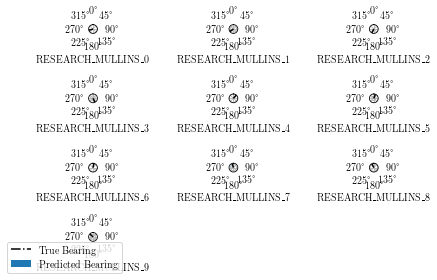

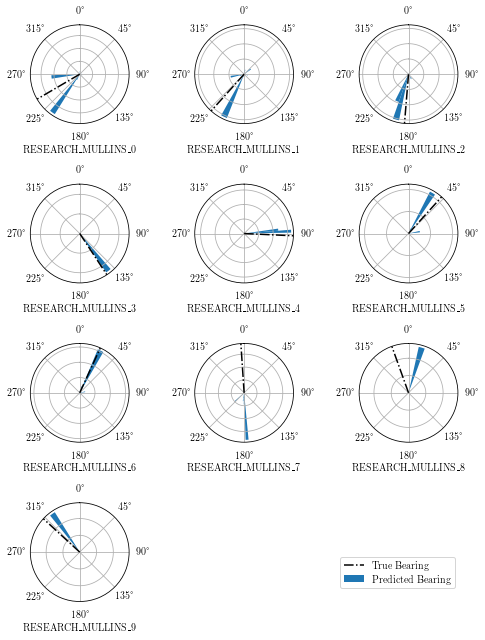

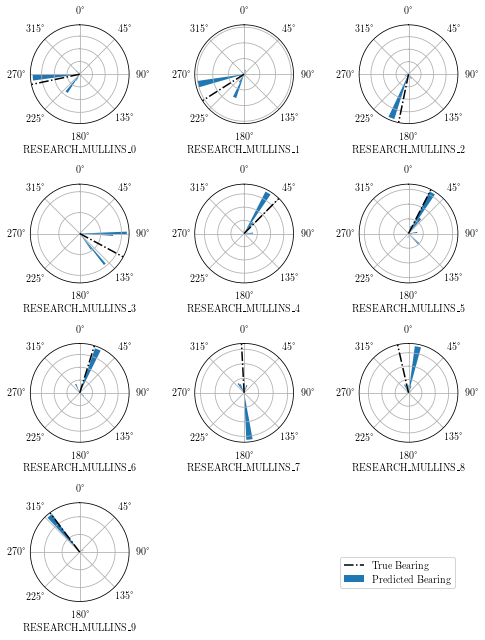

In [13]:
import capmap
capmap.setup('../../valid/capture/capture1', df)

cols = 3
rows = 4
bssids = capmap.aps.BSSID
bearings = capmap.bearings


for test in pd.unique(df.test):
    f, axarr = plt.subplots(rows,cols, subplot_kw=dict(polar=True))
    counter = 0
    for i in range(rows):
        for j in range(cols):      
            ax = axarr[i, j]
            if(counter) >= len(bssids): 
                f.delaxes(ax)
                continue
            bssid = bssids[counter]
            guesses = errors[(errors.test==test) & (errors.method=='PCHIP') & (errors.bssid==bssid)].guess
            if len(guesses) == 0:
                f.delaxes(ax)
                continue

            ax.set_yticklabels([])
            ax.set_theta_offset(np.radians(90))
            ax.set_theta_direction(-1)
            ax.set_xlabel(capmap.get_names_from_bssid([bssid], concat=False, escape=True)[0])
            bars = ax.hist(np.radians(guesses), bins=45, label="Predicted Bearing")
            truth = bearings[(bearings.test==test) & (bearings.bssid==bssid)].bearing.values[0]
            ax.axvline(np.radians(truth), 0, 1, color='k', linestyle='-.', label="True Bearing")

            counter += 1
   
    plt.rcParams["figure.figsize"] = [7, 9]
    plt.tight_layout()
    plt.legend(loc='upper right', bbox_to_anchor=(4.35, 0.5))
    plt.savefig(f'pchip_errors_{test}.png', dpi=300)
    plt.show()



Dropped 1 outlier coordinate


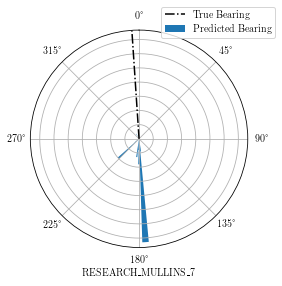

In [74]:
import capmap
capmap.setup('../../valid/capture/capture1', df)

bssid = capmap.get_bssids_from_names('RESEARCH_MULLINS_7')
bearings = capmap.bearings
test = 'capture-3'


f, ax = plt.subplots(1,1, subplot_kw=dict(polar=True))

guesses = errors[(errors.test==test) & (errors.method=='PCHIP') & (errors.bssid==bssid)].guess

ax.set_yticklabels([])
ax.set_theta_offset(np.radians(90))
ax.set_theta_direction(-1)
ax.set_xlabel(capmap.get_names_from_bssid([bssid], concat=False, escape=True)[0])
bars = ax.hist(np.radians(guesses), bins=45, label="Predicted Bearing")
truth = bearings[(bearings.test==test) & (bearings.bssid==bssid)].bearing.values[0]
ax.axvline(np.radians(truth), 0, 1, color='k', linestyle='-.', label="True Bearing")
plt.rcParams["figure.figsize"] = [4, 4]
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.13))
plt.savefig('pchip_polar.pgf')
plt.show()

